# Regression diagnostics in Python

*This tutorial is mainly based on {cite:t}`James2021` and the [statmodels documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html#Partial-Regression-Plots-(Crime-Data)) about regression plots.*

 When we fit a linear regression model to a particular data set, many problems may occur. Most common among these are the following {cite:p}`James2021`:

1. High-leverage points
1. Non-linearity of the response-predictor relationships and non-constant variance of error terms (heteroskedasticity)
1. Non-normally distributed errors
1. Correlation of error terms
1. Multicollinearity

As an example of how to identify and overcome these problems, we use data about the prestige of canadian occupations to estimate a regression model with `prestige` as the response and `income` and `education` as predictors.

 *Note that the observations are occupations. Review this [site](https://vincentarelbundock.github.io/Rdatasets/doc/carData/Prestige.html) to learn more about the data.*

 ## Python setup

In [1]:
import numpy as np
import pandas as pd

from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

## Import data

We can use the function `.datasets.get_rdataset` to load any R dataset available from the <a href="https://vincentarelbundock.github.io/Rdatasets/">Rdatasets package</a>. 

In [2]:
df = sm.datasets.get_rdataset("Duncan", "carData", cache=True).data

In [3]:
df.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


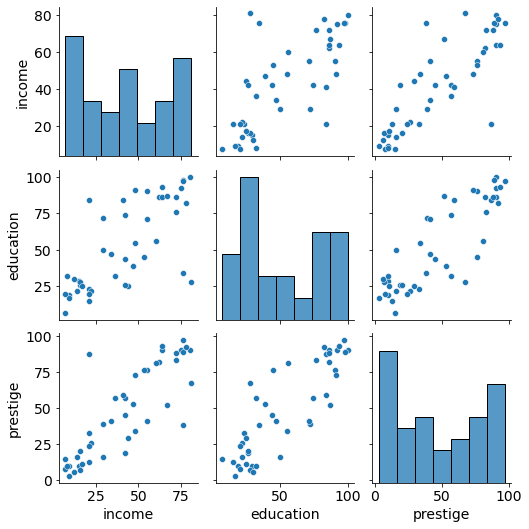

In [4]:
sns.pairplot(df);

## Model

In [4]:
# Estimate the model and save it as lm (linear model)
lm = ols("prestige ~ income + education", data=df).fit()

In [5]:
# print regression results
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           8.65e-17
Time:                        20:53:40   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

## Diagnostics

### Influence plots

 In a regression analysis, single observations can have a strong influence on the results of the model. For example, in the plot below we can see how a single outlying data point can cause a model to change the slope, even when the actual relationship between the other data points is substantially stronger. 

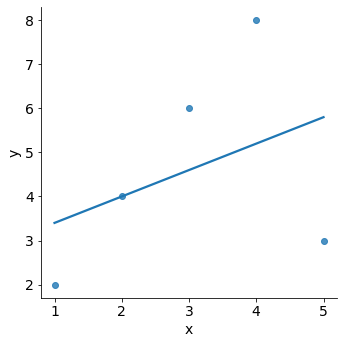

In [32]:
df_outlier = pd.DataFrame(
        { 'observation': pd.Categorical([ "A", "B", "C", "D", "E" ]),
          'x': np.array([1, 2, 3, 4, 5],dtype='int32'),
          'y': np.array([2, 4, 6, 8, 3],dtype='int32')}
        )

sns.lmplot(x="x", y="y", data=df_outlier, ci=False);

We just saw that outliers are observations for which the response $y_i$ is unusual given the predictor $x_i$. In contrast, observations with high **leverage** have an unusual value for $x_i$.

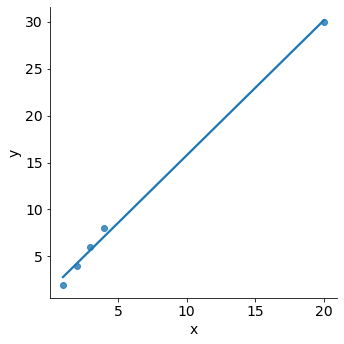

In [8]:
df_leverage = pd.DataFrame(
        { 'observation': pd.Categorical([ "A", "B", "C", "D", "E" ]),
          'x': np.array([1, 2, 3, 4, 20],dtype='int32'),
          'y': np.array([2, 4, 6, 8, 30],dtype='int32')}
        )

sns.lmplot(x="x", y="y", data=df_leverage, ci=False);

For example, observation E has high leverage, in that the predictor value for this observation is large relative to the other observations. The removal of the high leverage observation would have a substantial impact on the lregression line. 

> In general, high leverage observations tend to have a sizable impact on the estimated regression line.


Therefore, it is important to detect influential observations and to take them into consideration when interpreting the results. We can use influence plots to identify observations in our independent variables which have "unusual" values in copmarison to other values. 

Influence plots show the (externally) studentized residuals vs. the leverage of each observation.

#### Studentized residuals

Dividing a statistic by a sample standard deviation is called studentizing, in analogy with standardizing and normalizing. The basic idea is to: 

1. Delete the observations one at a time
2. Refit the regression model each time on the remaining n–1 observations. 
3. Compare the observed response values to their fitted values based on the models with the ith observation deleted. 
4. This produces unstandardized deleted residuals. 
5. Standardising the deleted residuals produces studentized deleted residuals (also known as externally studentized residuals)

In summary, externally studentized residuals are residuals that are scaled by their standard deviation. If an observation has an externally studentized residual that is larger than 3 (in absolute value) we can call it an outlier. Values greater then 2 (in absolute values) are also of interest.

#### Leverage

Leverage is a measure of how far away the independent variable values of an observation are from those of the other observations. High-leverage points are outliers with respect to the independent variables. 

#### Influence plot

Influence plots are used to identify influential data points. They depend on both the residual and leverage i.e they take itnto account both the x value and y value of the observation.

In the `.influence_plot` the influence of each point can be visualized by the `criterion` keyword argument. Options are Cook's distance and DFFITS, two measures of influence. Steps to compute Cook’s distance:

1. Delete observations one at a time.
2. Refit the regression model on remaining (n−1) observations
3. Examine how much all of the fitted values change when the ith observation is deleted.


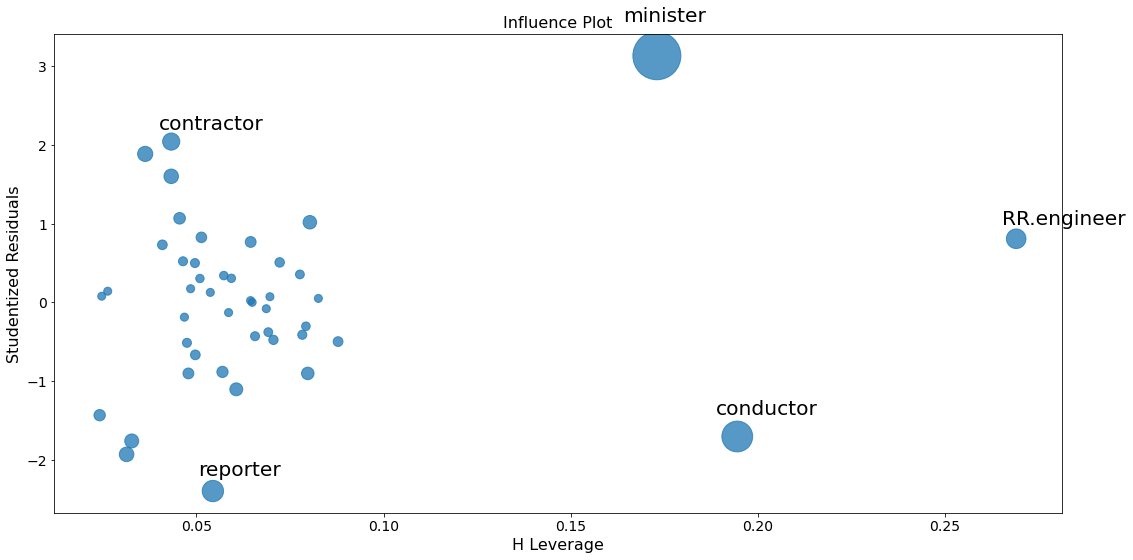

In [27]:
fig = sm.graphics.influence_plot(lm, criterion="cooks")
fig.tight_layout(pad=1.0)

To identify values with high influence, we look for observations with:

1. big blue points (high Cook's distance) and 
1. high leverage (X-axis) which additionally have 
2. high or low studentized residuals (Y-axis). 

There are a few worrisome observations with big blue dots in the plot:

- `RR.engineer` has large leverage but small residual. 
- Both `contractor` and `reporter` have low leverage but a large residual. 
- `Conductor` and `minister` have both high leverage and large residuals, and, therefore, large influence.

A general rule of thumb is that observations with a **Cook’s distance** over $4/n$ (where n is the number of observations) are possible outliers with leverage.  

In addition to our plot, we can use the function `.get_influence()` to assess the influence of each observation and compare them to the cricital Cook's distance :

In [9]:
# obtain Cook's distance 
lm_cooksd = lm.get_influence().cooks_distance[0]

# get length of df to obtain n
n = len(df["income"])

# calculate critical d
critical_d = 4/n
print('Critical Cooks distance:', critical_d)

# identification of potential outliers with leverage
out_d = lm_cooksd > critical_d

# output potential outliers with leverage
print(df.index[out_d], "\n", 
    lm_cooksd[out_d])

Critical Cooks distance: 0.08888888888888889
Index(['minister', 'reporter', 'conductor'], dtype='object') 
 [0.56637974 0.09898456 0.22364122]


We will deal with the crictical values in the section below. 

## Non-linearity and heteroscedasticity

One crucial assumption of the linear regression model is the **linear relationship** between the response and the dependent variables. 

We can identify non-linear relationships in the regression model residuals:

If the residuals are not equally spread around the horizontal line (where the residuals are zero) but instead show a pattern, then this gives us an indication for a non-linear relationship. 

We can deal with non-linear relationships via basis expansions (e.g. polynomial regression) and regression splines (see {cite:t}`Kuhn2019`](http://www.feat.engineering/numeric-one-to-many.html#numeric-basis-functions) )

Another important assumption is that the error terms have a constant variance (**homoscedasticity**). For instance, the variances of the error terms may increase with the value of the response. 

One can identify non-constant variances in the errors, or heteroscedasticity, from the presence of a funnel shape in a residual plot. 

When faced with this problem, one possible solution is to use weighted regression. This type of regression assigns a weight to each data point based on the variance of its fitted value.

Essentially, this gives small weights to data points that have higher variances, which shrinks their squared residuals. When the proper weights are used, this can eliminate the problem of heteroscedasticity.

### Partial Regression Plots

Since we are doing multivariate regressions, we cannot just look at individual bivariate plots (e.g., prestige and income) to identify the type of relationships between response and predictor. 

Instead, we want to look at the relationship of the dependent variable and independent variables conditional on the other independent variables. We can do this through using *partial regression plots*, otherwise known as *added variable plots*. 

With partial regression plots you can

1. investigate the relationship between a dependent and independent variables.
2. identify the effects of the individual data values on the estimation of a coefficient. 
3. investigate violations of underlying assumptions such as linearity and homoscedasticity.

If we want to identify the relationship between `prestige` and `income`, we would proceed as follows: 

> First, let`s name the independent variable of interest $X_k$ and all other independent variables $X_{\sim k}$.

<br/>

1. Compute a regression model by regressing the response variable versus the independent variables excluding $X_k$:
    - response variable: `prestige`
    - $X_k$: `income`
    - $X_{\sim k}$: `education`
    - Model($X_{\sim k}$): `(prestige ~ education)`  

<br/>

2. Compute the residuals of Model($X_{\sim k}$): 
    - $R_{X_{\sim k}}$: residuals of Model($X_{\sim k}$): 

<br/>

3. Compute a new regression model by regressing $R_{X_{\sim k}}$ on $X_{\sim k}$. 
    - Model($X_k$): $R_{X_{\sim k}}$ ~ `income`

<br/>

4. Compute the residuals of Model($X_k$): 
    - $R_{X_{k}}$: residuals of Model($X_{k}$): 

<br/>

5. Make a partial regression plot by plotting the residuals from $R_{X_{\sim k}}$ against the residuals from $R_{X_{k}}$:
    - Plot with X = $R_{X_{k}}$ and Y = $R_{X_{\sim k}}$

<br/>

For a quick check of all the regressors, you can use `plot_partregress_grid`. These plots will not label the 
points, but you can use them to identify problems and then use `plot_partregress` to get more information.

eval_env: 1
eval_env: 1
eval_env: 1


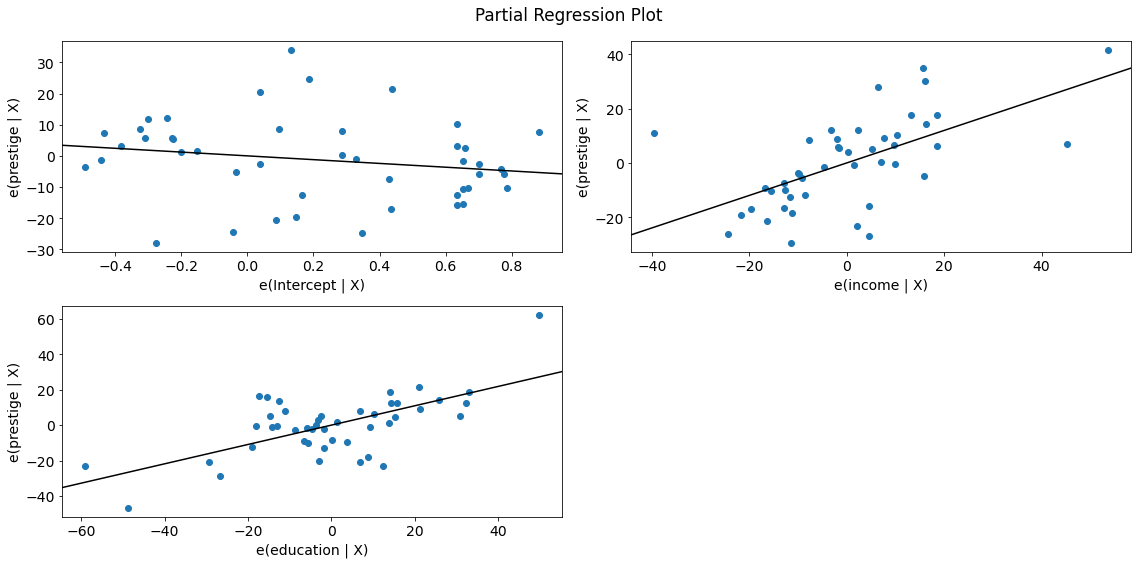

In [64]:
fig = sm.graphics.plot_partregress_grid(lm)
fig.tight_layout(pad=1.0)

We observe a strong, positive relationship between prestige and income as well as between prestige and education. The relationship seems to be linear in both cases.

Next, let's take a closer look at the observations.

eval_env: 1


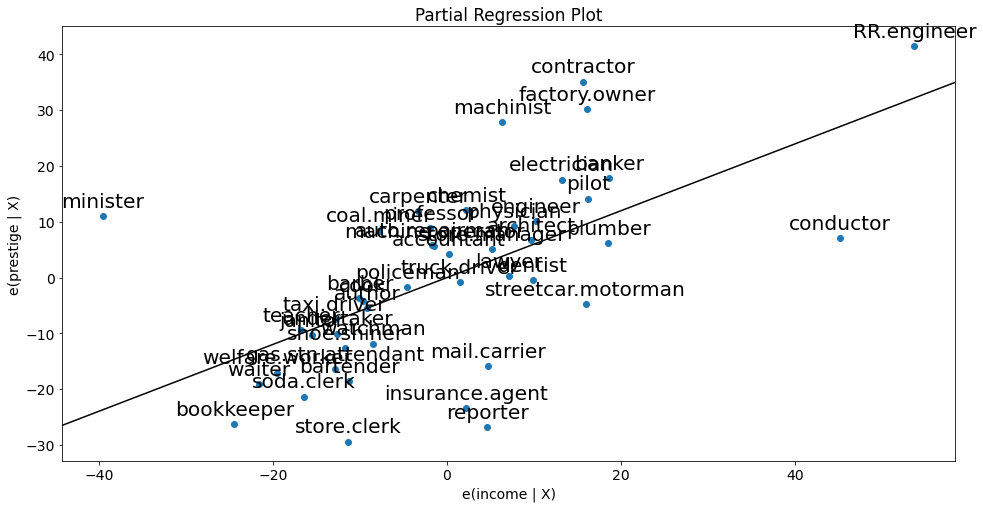

In [45]:
sm.graphics.plot_partregress(
                             endog='prestige', # response
                             exog_i='income', # variable of interest
                             exog_others=['education'], # other predictors
                             data=df,  # dataframe
                             obs_labels=True # show labels
                             );

eval_env: 1


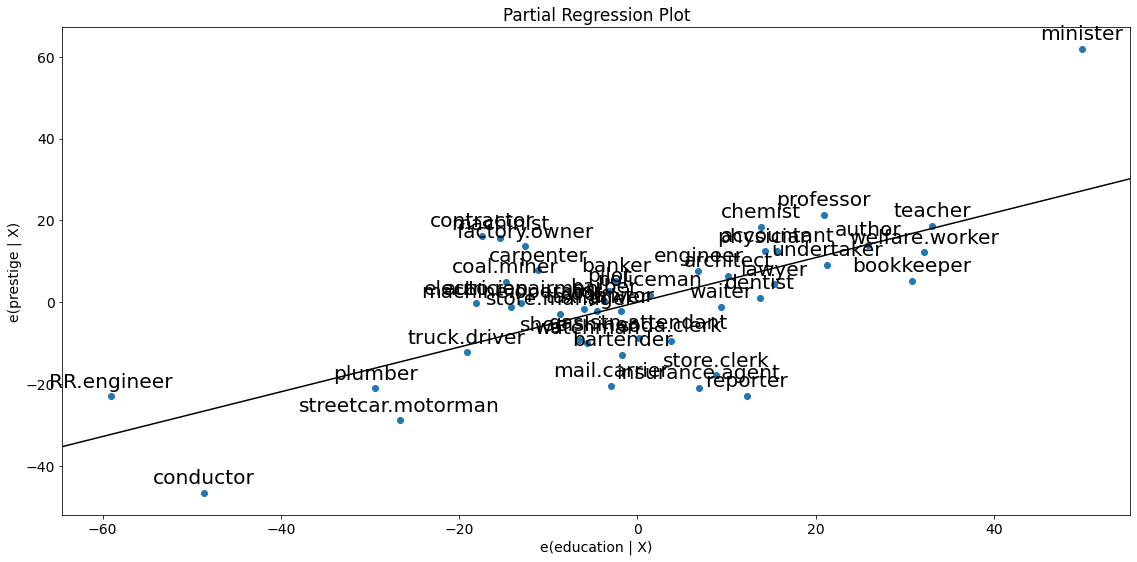

In [63]:
# same procedure for education
fig = sm.graphics.plot_partregress("prestige", "education", ["income"], data=df)
fig.tight_layout(pad=1.0)

The partial regression plots confirm the influence of `conductor`, `minister` on the partial relationships between prestige and the predictors income and education. The influence of `reporter` is less obvious but since the observation was considered critical according to Cook`s D, we also drop this case.

Note that the cases potentially decrease the effect of income and education on prestige. Dropping these cases confirms this. Compare the regression summary below with our initial summary (see $R^2$, adjusted $R^2$, F-statistic and the new coefficients).

In [10]:
# make a subset and flag as TRUE if index doesn't contain ...
subset = ~df.index.isin(["conductor", "minister", "reporter"])

print(df.index, "\n", subset)

Index(['accountant', 'pilot', 'architect', 'author', 'chemist', 'minister',
       'professor', 'dentist', 'reporter', 'engineer', 'undertaker', 'lawyer',
       'physician', 'welfare.worker', 'teacher', 'conductor', 'contractor',
       'factory.owner', 'store.manager', 'banker', 'bookkeeper',
       'mail.carrier', 'insurance.agent', 'store.clerk', 'carpenter',
       'electrician', 'RR.engineer', 'machinist', 'auto.repairman', 'plumber',
       'gas.stn.attendant', 'coal.miner', 'streetcar.motorman', 'taxi.driver',
       'truck.driver', 'machine.operator', 'barber', 'bartender',
       'shoe.shiner', 'cook', 'soda.clerk', 'watchman', 'janitor', 'policeman',
       'waiter'],
      dtype='object') 
 [ True  True  True  True  True False  True  True False  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


In [11]:
# compute regression without influential cases
lm2 = ols("prestige ~ income + education", data=df, subset=subset).fit()

print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     169.0
Date:                Fri, 12 Nov 2021   Prob (F-statistic):           6.13e-20
Time:                        21:08:01   Log-Likelihood:                -157.02
No. Observations:                  42   AIC:                             320.0
Df Residuals:                      39   BIC:                             325.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.2414      3.391     -2.136      0.0

### CCPR plots

The Component-Component plus Residual (CCPR) plot provides another way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables. They are also a good way to see if the predictors have a linear relationship with the dependent variable. 

A partial residual plot attempts to model the residuals of one predictor against the dependent variable. A component residual plot adds a line indicating where the line of best fit lies. A significant difference between the residual line and the actual distrubution ov values indicates that the predictor does not have a linear relationship with the dependent variable. 

The partial residuals plot is defined as $\text{Residuals} + B_iX_i \text{ }\text{ }$ versus $X_i$. 

The component adds $B_iX_i$ versus $X_i$ to show where the fitted line would lie. 

*Care should be taken if $X_i$ is highly correlated with any of the other independent variables (see multicollinearity). If this is the case, the variance evident in the plot will be an underestimate of the true variance.*

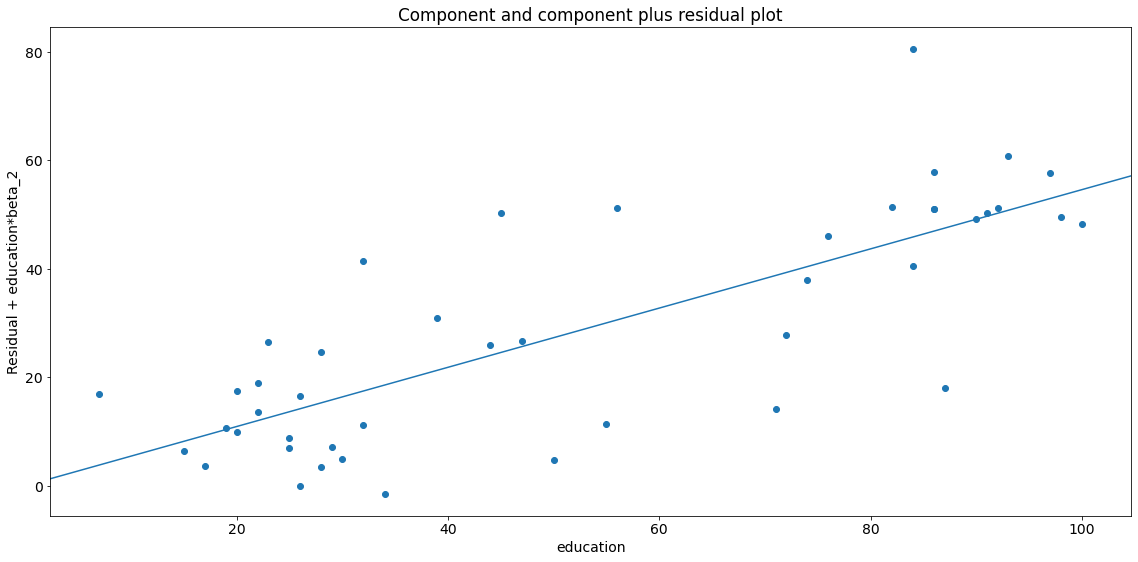

In [12]:
fig = sm.graphics.plot_ccpr(lm, "education")
fig.tight_layout(pad=1.0)

As you can see the relationship between the variation in prestige explained by education conditional on income seems to be linear, though you can see there are some observations that are exerting considerable influence on the relationship. 

We can quickly look at more than one variable by using `plot_ccpr_grid`.

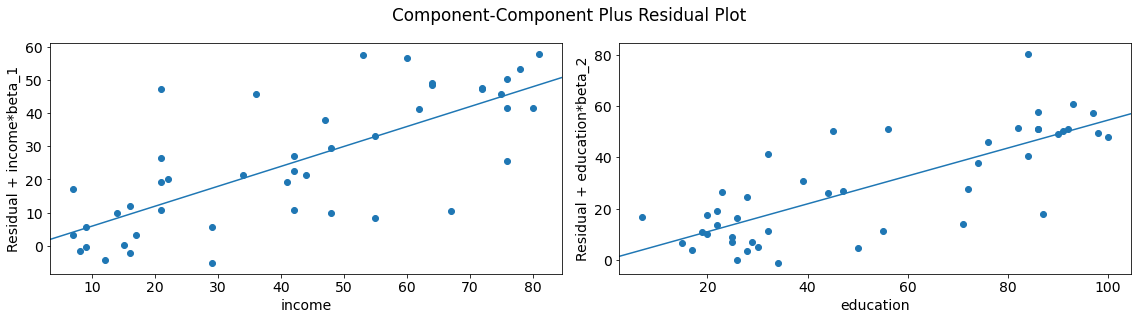

In [14]:
fig = sm.graphics.plot_ccpr_grid(lm)
fig.tight_layout(pad=1.0)

###  Residuals vs fitted plot

Residual plots are also a very useful graphical tool for identifying non-linearity as well as heteroscedasticity. 

Again, we can use the function of the *partial regression plots* but this time include all predictor variables in the model. The residuals of this plot are the same as those of the regression fit of the original model with all predictors. 

You can use the plot to see the violation of underlying assumptions such as linearity and homoskedasticity.

eval_env: 1


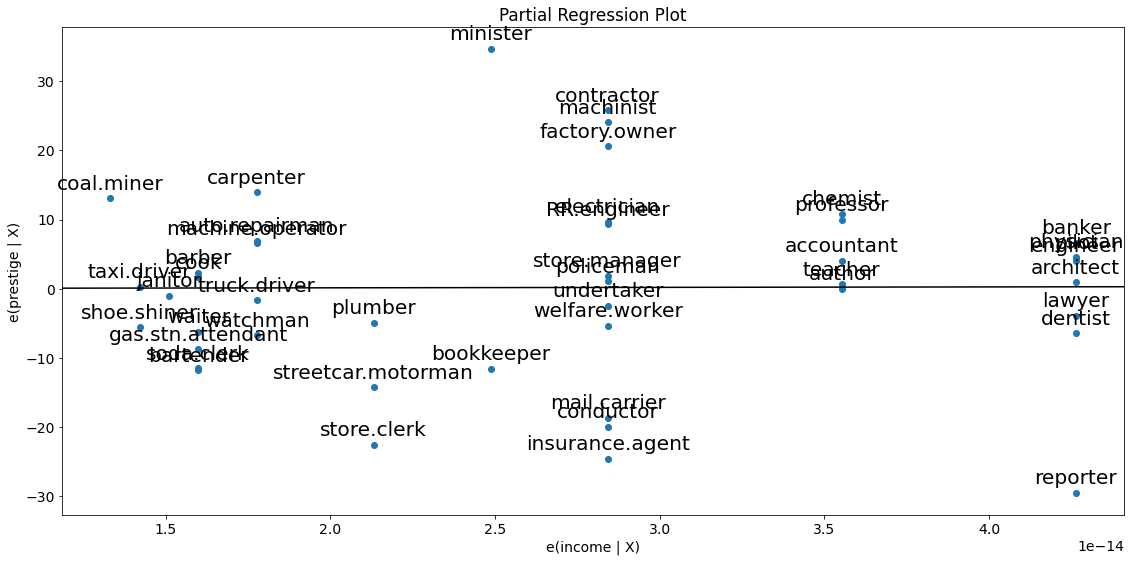

In [17]:
# same procedure for education
fig = sm.graphics.plot_partregress("prestige", "income", ["income", "education"], data=df)
fig.tight_layout(pad=1.0)

This plot shows if residuals are spread equally along the ranges of predictors. This is how we can check the assumption of equal variance (**homoscedasticity**). 

It’s good if we observe equally (randomly) spread points along the horizontal line.

In our model the residuals begin to spread wider along the y-axis as it passes the x value of around 2. Because the residuals spread wider and wider with an increase of x, this could be an indication of heteroskedasticity. However, the pattern is not obvious.

#### Breusch-Pagan test:

Test assumes homoskedasticity (null hypothesis). If one of the test statistics is significant, then you have evidence of heteroskedasticity. 

In [21]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sm.stats.het_breuschpagan(lm.resid, lm.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 0.5752191351127306),
 ('p-value', 0.7500543806429694),
 ('f-value', 0.27191134322318933),
 ('f p-value', 0.7632527707017838)]

### Single Variable Regression Diagnostics

The `plot_regress_exog` function is a convenience function that gives a 2x2 plot containing the 

1. dependent variable and fitted values with confidence intervals vs. the independent variable chosen, 
2. the residuals of the model vs. the chosen independent variable, 
3. a partial regression plot, and a 
4. CCPR plot. This function can be used for quickly checking modeling assumptions with respect to a single regressor.

eval_env: 1


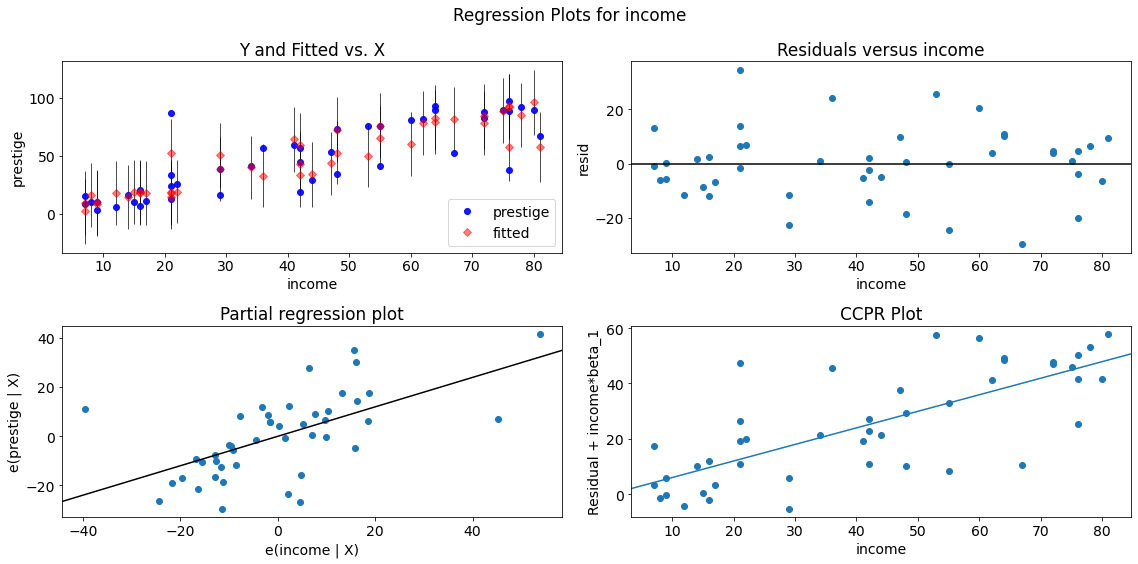

In [15]:
fig = sm.graphics.plot_regress_exog(lm, "income")
fig.tight_layout(pad=1.0)

#### Fit Plot

The plot_fit function plots the fitted values versus a chosen independent variable. It includes prediction confidence intervals and optionally plots the true dependent variable.

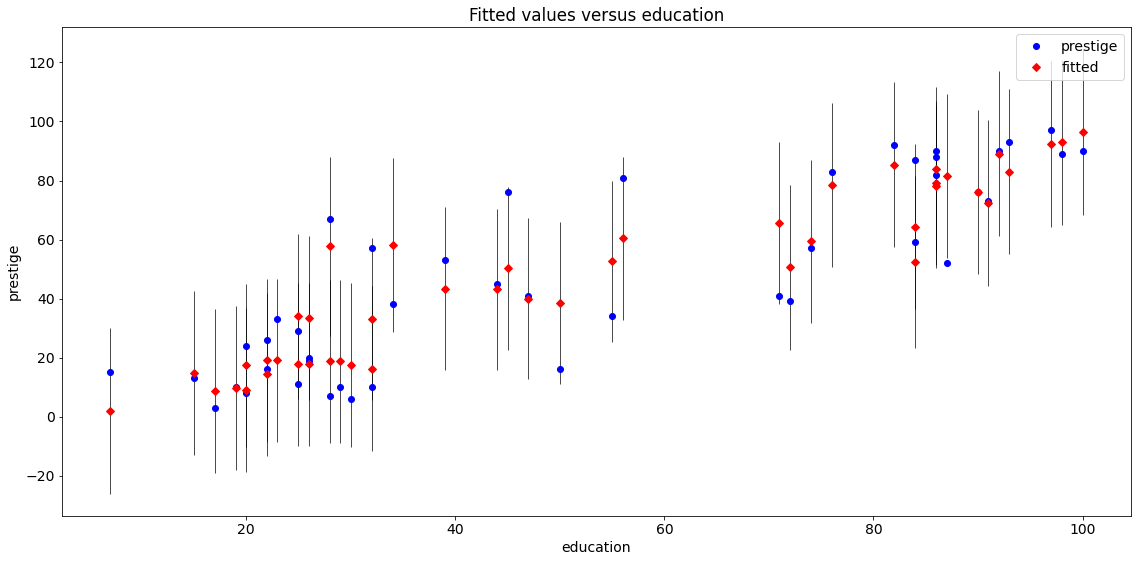

In [15]:
fig = sm.graphics.plot_fit(lm, "education")
fig.tight_layout(pad=1.0)

## Statewide Crime 2009 Dataset

Compare the following to http://www.ats.ucla.edu/stat/stata/webbooks/reg/chapter4/statareg_self_assessment_answers4.htm

Though the data here is not the same as in that example. You could run that example by uncommenting the necessary cells below.

In [16]:
# dta = pd.read_csv("http://www.stat.ufl.edu/~aa/social/csv_files/statewide-crime-2.csv")
# dta = dta.set_index("State", inplace=True).dropna()
# dta.rename(columns={"VR" : "crime",
#                    "MR" : "murder",
#                    "M"  : "pctmetro",
#                    "W"  : "pctwhite",
#                    "H"  : "pcths",
#                    "P"  : "poverty",
#                    "S"  : "single"
#                    }, inplace=True)
#
# crime_model = ols("murder ~ pctmetro + poverty + pcths + single", data=dta).fit()

In [17]:
dta = sm.datasets.statecrime.load_pandas().data

In [18]:
crime_model = ols("murder ~ urban + poverty + hs_grad + single", data=dta).fit()
print(crime_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 murder   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     50.08
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           3.42e-16
Time:                        19:26:54   Log-Likelihood:                -95.050
No. Observations:                  51   AIC:                             200.1
Df Residuals:                      46   BIC:                             209.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -44.1024     12.086     -3.649      0.0

### Partial Regression Plots (Crime Data)

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


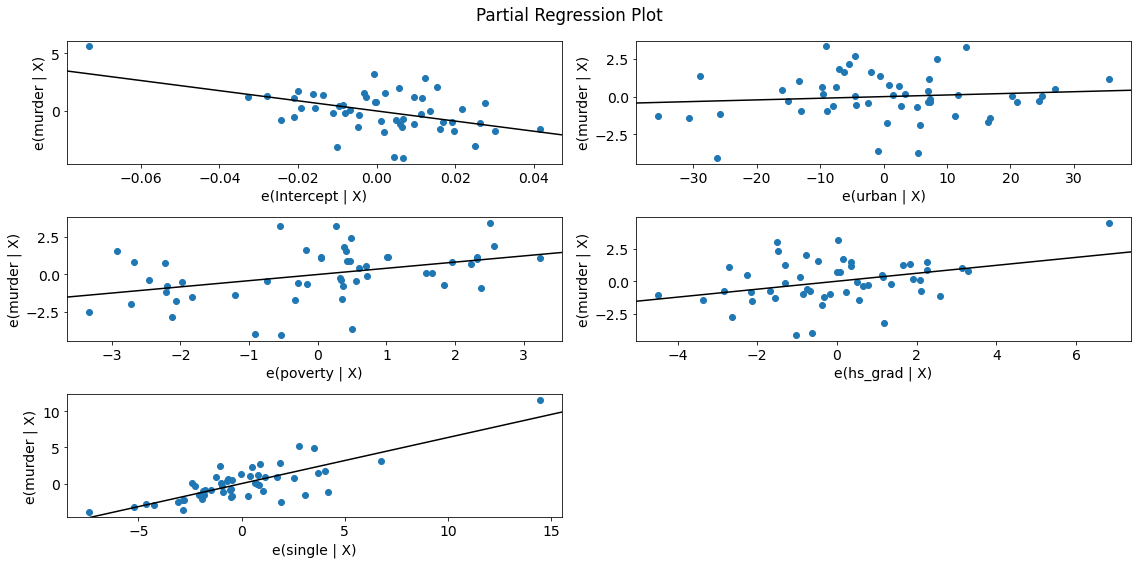

In [19]:
fig = sm.graphics.plot_partregress_grid(crime_model)
fig.tight_layout(pad=1.0)

eval_env: 1


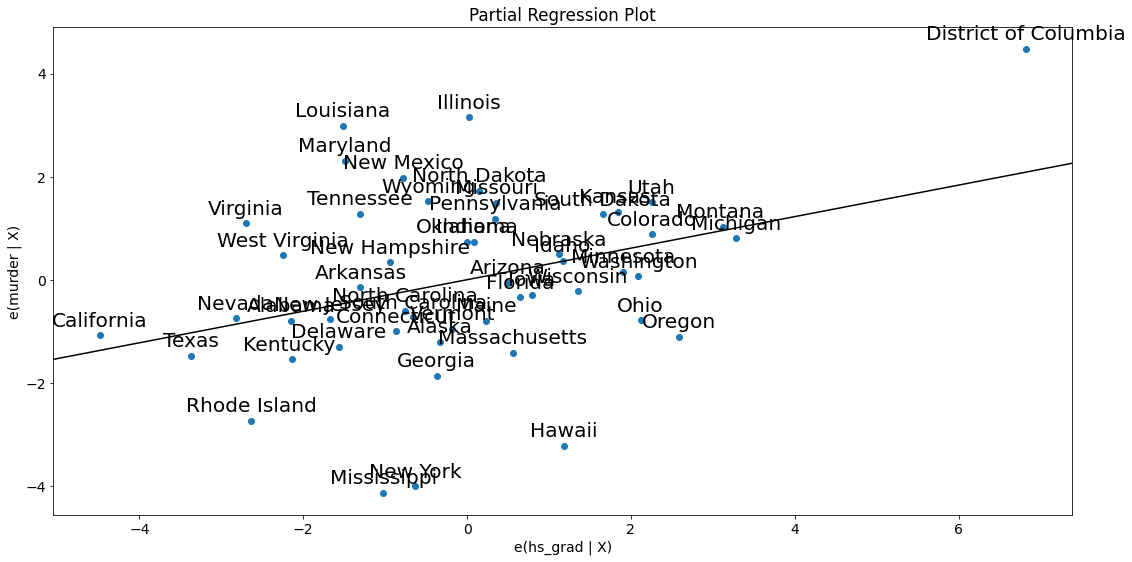

In [20]:
fig = sm.graphics.plot_partregress(
    "murder", "hs_grad", ["urban", "poverty", "single"], data=dta
)
fig.tight_layout(pad=1.0)

### Leverage-Resid<sup>2</sup> Plot

Closely related to the influence_plot is the leverage-resid<sup>2</sup> plot.

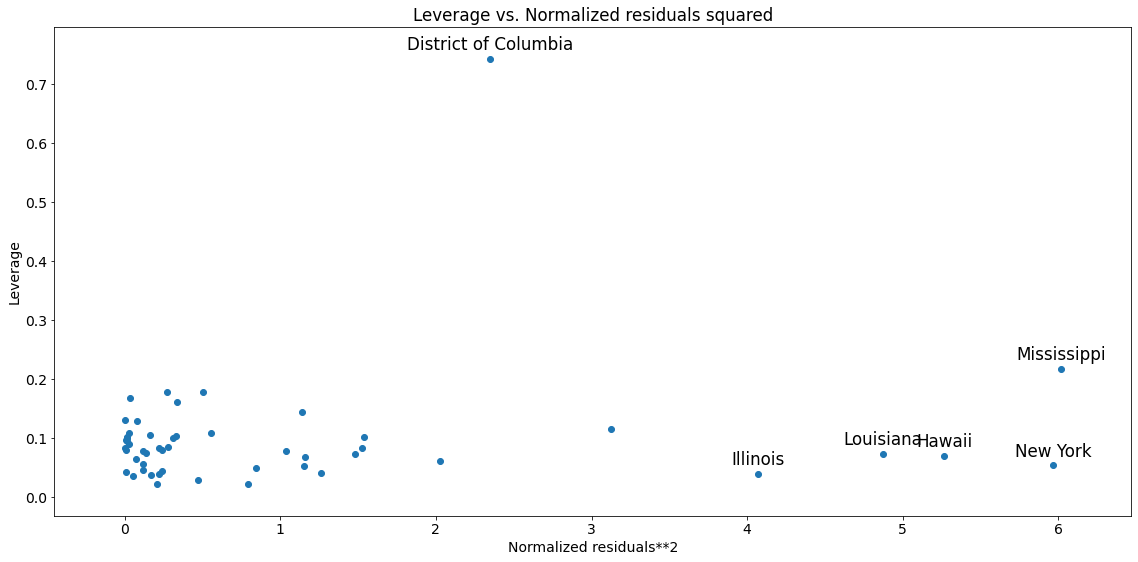

In [21]:
fig = sm.graphics.plot_leverage_resid2(crime_model)
fig.tight_layout(pad=1.0)

### Influence Plot

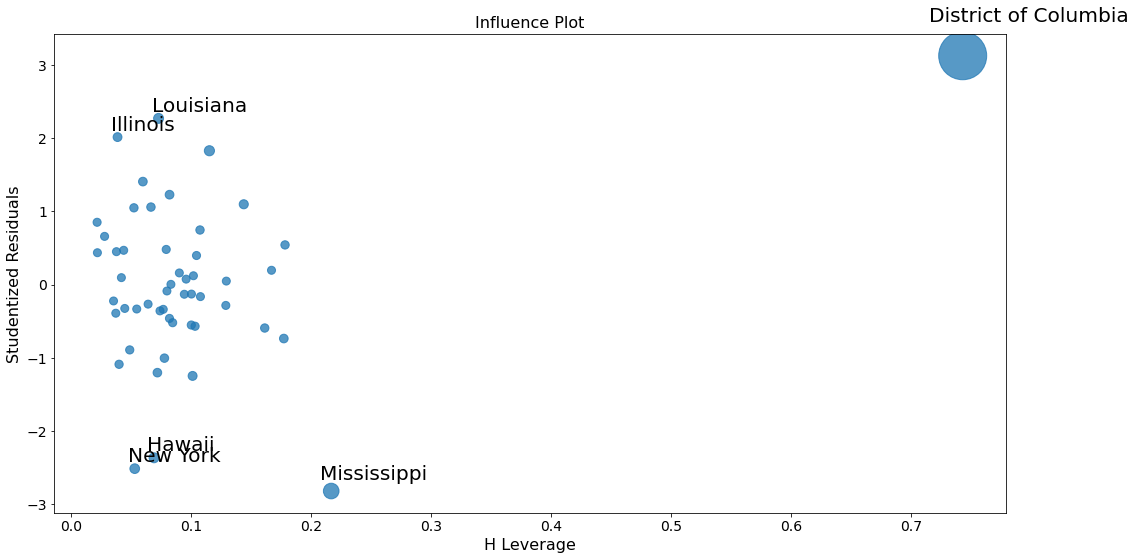

In [22]:
fig = sm.graphics.influence_plot(crime_model)
fig.tight_layout(pad=1.0)

### Using robust regression to correct for outliers.

Part of the problem here in recreating the Stata results is that M-estimators are not robust to leverage points. MM-estimators should do better with this examples.

In [23]:
from statsmodels.formula.api import rlm

In [24]:
rob_crime_model = rlm(
    "murder ~ urban + poverty + hs_grad + single",
    data=dta,
    M=sm.robust.norms.TukeyBiweight(3),
).fit(conv="weights")
print(rob_crime_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 murder   No. Observations:                   51
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            4
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 08 Nov 2021                                         
Time:                        19:26:57                                         
No. Iterations:                    50                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.2986      9.494     -0.453      0.6

In [25]:
# rob_crime_model = rlm("murder ~ pctmetro + poverty + pcths + single", data=dta, M=sm.robust.norms.TukeyBiweight()).fit(conv="weights")
# print(rob_crime_model.summary())

There is not yet an influence diagnostics method as part of RLM, but we can recreate them. (This depends on the status of [issue #888](https://github.com/statsmodels/statsmodels/issues/808))

In [26]:
weights = rob_crime_model.weights
idx = weights > 0
X = rob_crime_model.model.exog[idx.values]
ww = weights[idx] / weights[idx].mean()
hat_matrix_diag = ww * (X * np.linalg.pinv(X).T).sum(1)
resid = rob_crime_model.resid
resid2 = resid ** 2
resid2 /= resid2.sum()
nobs = int(idx.sum())
hm = hat_matrix_diag.mean()
rm = resid2.mean()

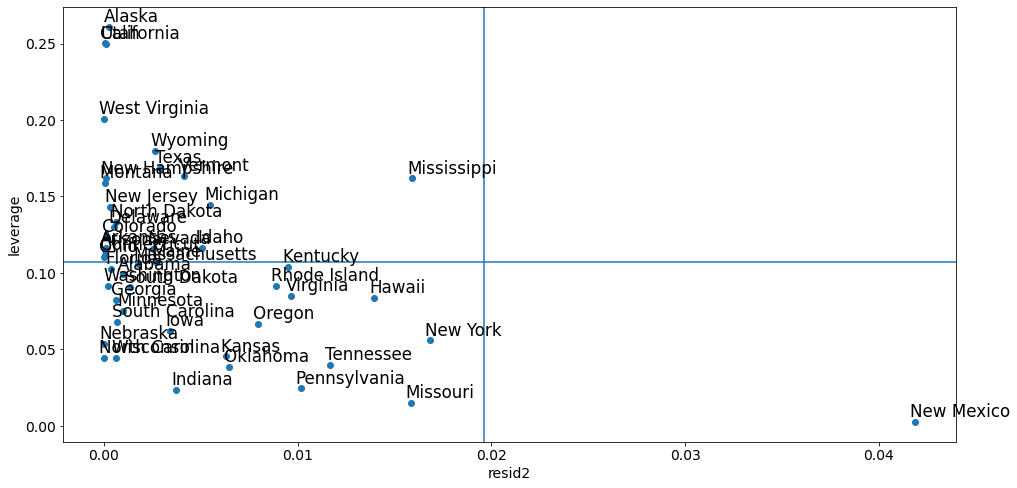

In [27]:
from statsmodels.graphics import utils

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(resid2[idx], hat_matrix_diag, "o")
ax = utils.annotate_axes(
    range(nobs),
    labels=rob_crime_model.model.data.row_labels[idx],
    points=lzip(resid2[idx], hat_matrix_diag),
    offset_points=[(-5, 5)] * nobs,
    size="large",
    ax=ax,
)
ax.set_xlabel("resid2")
ax.set_ylabel("leverage")
ylim = ax.get_ylim()
ax.vlines(rm, *ylim)
xlim = ax.get_xlim()
ax.hlines(hm, *xlim)
ax.margins(0, 0)

### Non-normally distributed errors

It can be helpful if the residuals in the model are random, normally distributed variables with a mean of 0. 

This assumption means that the differences between the predicted and observed data are most frequently zero or very close to zero, and that differences much greater than zero happen only occasionally.

Don't confuse this assumption with the idea that predictors have to be normally distributed, which they don’t. In small samples a lack of normality invalidates confidence intervals and significance tests, whereas in large samples it will not because of the central limit theorem. 

If you are concerned only with estimating the model parameters (and not significance tests and confidence intervals) then this assumption barely matters. If you bootstrap confidence intervals then you can ignore this assumption.

#### Jarque-Bera test

The Jarque–Bera test is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. 

The null hypothesis is a joint hypothesis of the skewness being zero and the excess kurtosis being zero. 

Samples from a normal distribution have an expected skewness of 0 and an expected excess kurtosis of 0 (which is the same as a kurtosis of 3). As the definition of JB shows, any deviation from this increases the JB statistic.

In [18]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.jarque_bera(lm.resid)

lzip(name, test)

[('Jarque-Bera', 0.5195278349686433),
 ('Chi^2 two-tail prob.', 0.7712336390906139),
 ('Skew', 0.1549318677987544),
 ('Kurtosis', 3.425518480614924)]

#### Omnibus normtest

Test for normal distribution of residuals. In this case, we use the $Chi^2$-Test. The Chi-Square Test for normality allows us to check whether or not the model residuals follow an approximately normal distribution.

Our null hypothesis is that the residuals are from a normal distribution.

In [19]:
name = ['Chi^2', 'Two-tail probability']
test = sm.stats.omni_normtest(lm.resid)
lzip(name, test)

[('Chi^2', 1.2788071145675917), ('Two-tail probability', 0.5276070175778638)]

### Correlation of error terms

An important assumption of the linear regression model is that the error terms are uncorrelated.

Such correlations frequently occur in the context of time series data, which consists of observations for which measurements are obtained at discrete points in time. In many cases, observations that are obtained at adjacent time points will have positively correlated errors. In order to determine if this is the case for a given data set, we can plot the residuals from our model as a function of time. If the errors are uncorrelated, then there should be no discernible pattern.

Correlation among the error terms can also occur outside of time series data. For instance, consider a study in which individuals’ heights are predicted from their weights. The assumption of uncorrelated errors could be violated if some of the individuals in the study are members of the same family, or eat the same diet, or have been exposed to the same environmental factors. 

In general, the assumption of uncorrelated errors is extremely important for linear regression as well as for other statistical methods, and good experimental design is crucial in order to mitigate the risk of such correlations.

A test of autocorrelation that is designed to take account of the regression model is the **Durbin-Watson test**. It is used to test the hypothesis that there is no **lag one autocorrelation** in the residuals. If there is no autocorrelation, the Durbin-Watson distribution is symmetric around 2. 

A small p-value indicates there is significant autocorrelation remaining in the residuals.

As a rough rule of thumb, if Durbin–Watson is less than 1.0, there may be cause for alarm. Small values of d indicate successive error terms are positively correlated. If d > 2, successive error terms are negatively correlated.

In [20]:
sm.stats.durbin_watson(lm.resid)

1.458332862235202